<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/Hertel_region-based-attention-visualiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Hertel estimation_判断根拠の可視化**

In [9]:
from __future__ import print_function, division
!pip install --q torch_optimizer

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.io import read_image
import matplotlib.pyplot as plt
import re
import time
import os
import copy
import statistics
import math
from decimal import Decimal, ROUND_HALF_UP
import shutil
import codecs
from scipy import stats
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install --q pingouin
import pingouin as pg

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

random_seed = 3 #shuffleのシード

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Wed Nov 23 16:13:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   1420MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
DATASET_PATH = "/content/drive/MyDrive/発表/2022眼科AI学会/dataset_250px_uni_eye"
model_path = "/content/drive/MyDrive/発表/2022眼科AI学会/models_Hertel_estimation/5-fold-crossvalidation/eye_fold0_RepVGGA2.pth"
csv_path = "/content/drive/MyDrive/発表/2022眼科AI学会/Hertel_unilateral.csv"


PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 3
TRAIN_CROP_SCALE =(0.75,1.0)
VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


train_data_transforms = nn.Sequential(
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE),
                #transforms.RandomRotation(ROTATION_DEGREES),
                transforms.RandomHorizontalFlip(),
                transforms.ConvertImageDtype(torch.float32),
                transforms.Normalize(TRAIN_NORMALIZE_PARAM[0], TRAIN_NORMALIZE_PARAM[1])
                ).to(device)
val_data_transforms = nn.Sequential(
                transforms.Resize(PX),
                transforms.ConvertImageDtype(torch.float32),
                transforms.Normalize(VAL_NORMALIZE_PARAM[0], VAL_NORMALIZE_PARAM[1])
                ).to(device)

def my_round(x, d=2):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p

In [12]:
################
# Create datasets #
################

class Create_Datasets(Dataset):
     
    def __init__(self, image_path_list_list, idxs, csv_path, transform):
        self.transform = transform
        self.path_list_list = path_list_list
        self.idxs = idxs
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for idx in idxs:
            path_0, path_1, path_2 = path_list_list[0][idx], path_list_list[1][idx], path_list_list[2][idx]
            base_name = os.path.splitext(os.path.basename(path_0))[0] #フォルダより画像番号を抜き出す
            hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([path_0, path_1, path_2, hertel]) #[path, hertel]の組み合わせをリストに追加する
            item_paths = self.item_paths
 
    def __len__(self):
        return len(self.item_paths)
     
    def __getitem__(self, index):
        # [tensor[path0, path1, path2], hertel_value]
        def tensor_img(image_path):
            pilr_image = Image.open(image_path).convert("RGB")
            tensor_image = transforms.functional.to_tensor(pilr_image)
            tensor_image = self.transform(tensor_image)
            # tensor_image = self.transform(pilr_image).float()
            # tensor_image = self.transform(read_image(path=image_path))
            return tensor_image
        tensor_image_0 = tensor_img(self.item_paths[index][0]) 
        tensor_image_1 = tensor_img(self.item_paths[index][1])      
        tensor_image_2 = tensor_img(self.item_paths[index][2])      
        tensor_image = torch.stack([tensor_image_0, tensor_image_1, tensor_image_2])
        #tensor_image = tensor_image_0
        hertel = self.item_paths[index][3]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target


######################
# Test with early stopping #
######################

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


#1つずつ解析するバージョン
def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device, area_num, alpha=0):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        # define scaler for fastening
        scaler = torch.cuda.amp.GradScaler() 

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,area_num])  #16,3,3,224,224 --> 16,3,224,224 (バッチサイズの次の次元でスライスすることによりtensorを取り出す)
            # calculate the loss
            with torch.cuda.amp.autocast(): 
                loss = loss_func(output, target)

                ################
                ##l2_normalization##
                ################
                l2 = torch.tensor(0., requires_grad=True)
                for w in model.parameters():
                    l2 = l2 + torch.norm(w)**2
                loss = loss + alpha*l2

            # backward pass: compute gradient of the loss with respect to model parameters
            scaler.scale(loss).backward()
            # perform a single optimization step (parameter update)
            scaler.step(optimizer) 
            scaler.update() 

            # record training loss
            train_losses.append(loss.item())


        ######################    
        # validate the model #
        ######################
       
        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:  
            #target = target.squeeze(1)         
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor[:,area_num])
            # calculate the loss
            loss = loss_func(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )
        
        print(print_msg)

        
        #Scheduler step for SGD
        #scheduler.step() #val_lossが下がらなければ減衰
        

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [14]:
##################
# Define RepVGG-A2 #
##################

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.dropout = nn.Dropout(0.25) #Define proportion or neurons to dropout
        self.fc = nn.Linear(in_features=1408, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x) #dropoutを1層追加
        x = self.fc(x)
        return x

/content/drive/MyDrive/発表/2022眼科AI学会/dataset_250px_uni_eye/461_L.JPG
RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momen

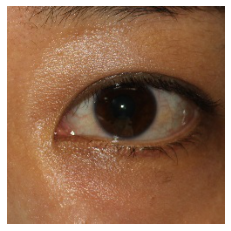

target: 18.0, output: 18.345563888549805


In [16]:
# Interference several images
%matplotlib inline

#Datasetの読み込み
image_path_list = glob.glob(f"{DATASET_PATH}/*")[0:1]
csv_path = csv_path

#ラベルの読み込み
with codecs.open(csv_path, "r", "Shift-JIS", "ignore") as file:
        df = pd.read_csv(file, index_col=None, header=0)

targets, outputs = [], []
for path in image_path_list:
    print(path)
    base_name = os.path.splitext(os.path.basename(path))[0] #フォルダより画像番号を抜き出す
    hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
    targets.append(hertel) 


#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)
    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる
    return(image_tensor)

#Interference
model_ft = create_RepVGG_A2(deploy=False) 
model_ft = mod_RepVGG()
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval() # prep model for evaluation
print(f"model_path: {model_path}")
 
for img in image_path_list:
      Image.register_open
      with torch.inference_mode():
          image_tensor = image_transform(img)  
          # forward pass: compute predicted outputs by passing inputs to the model
          outputs.append(model_ft(image_tensor).item()) 

for path, target, output in zip(image_path_list, targets, outputs):
    imgPIL = Image.open(path)  # 画像読み込み
    plt.imshow(imgPIL)
    plt.axis("off")
    plt.show()
    print(f"target: {target}, output: {output}")

In [ ]:
from PIL import Image, ImageDraw
image_path_list = glob.glob(f"{DATASET_PATH}/*")[0:1]
image = Image.open(image_path_list[0])
image = image.resize((224, 224))

#ラベルの読み込み
with codecs.open(csv_path, "r", "Shift-JIS", "ignore") as file:
        df = pd.read_csv(file, index_col=None, header=0)

targets = []
for path in image_path_list:
    base_name = os.path.splitext(os.path.basename(path))[0] #フォルダより画像番号を抜き出す
    hertel = df[df['number']==str(base_name)].iloc[0,1] #CSV上で一致した番号の画像についてHertel値を抜き出す
    targets.append(hertel) 

def randmask(image):
    coordinates = np.sort(np.random.randint(0,225, (2,2)))

    while np.all(coordinates[:,1]-coordinates[:,0] > 50) == False: #幅が50pix未満の場合は設定し直す
        coordinates = np.sort(np.random.randint(0,225, (2,2)))
    x1 = coordinates[0,0]
    y1 = coordinates[1,0]
    x2 = coordinates[0,1]
    y2 = coordinates[1,1]

    # image_1 = image.copy()
    # rect_d = ImageDraw.Draw(image_1)
    # rect_d.rectangle(
    #     [(x1, y1), (x2, y2)], fill=(0, 0, 0)
    # )

    black = Image.new('RGB', (224, 224), 0)
    mask = Image.new("L", (224,224), 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle([(x1, y1), (x2, y2)], fill=255)
    image_1 = Image.composite(black, image, mask)
    image_2 = Image.composite(image, black, mask)
    return image_1, image_2, [x1, y1, x2, y2] #PIL


#評価のための画像下処理
def image_transform(image):    
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)
    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる
    return(image_tensor)


#Load model
model_ft = create_RepVGG_A2(deploy=False) 
model_ft = mod_RepVGG()
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval() # prep model for evaluation
print(f"model_path: {model_path}")

#消去なし画像のアウトプットを確認
orig_output = []
for img in image_path_list:
      with torch.inference_mode():
          img = Image.open(img)
          image_tensor = image_transform(img)  
          # forward pass: compute predicted outputs by passing inputs to the model
          orig_output.append(model_ft(image_tensor).item()) 

for path, target, output in zip(image_path_list, targets, outputs):
    imgPIL = Image.open(path)  # 画像読み込み
    plt.imshow(imgPIL)
    plt.axis("off")
    plt.show()
    print(f"target: {target}, output: {output}")

In [ ]:
attention = np.zeros((224, 224), dtype=int)
time_sta = time.time()

renew = 0
for epoch in range(200):
    masked_img = [0]*2
    outputs = []
    masked_img[0], masked_img[1], c = randmask(image) #c:画像内の座標

    for img in masked_img:
          with torch.inference_mode():
              image_tensor = image_transform(img)  
              # forward pass: compute predicted outputs by passing inputs to the model
              outputs.append(model_ft(image_tensor).item()) 

    for i, imgPIL in enumerate(masked_img):
        plt.imshow(imgPIL)
        plt.axis("off")
        plt.show()
        print(f"epoch {epoch}")
        print(f"target: {targets[0]}, output: {outputs[i]}")

        time_end = time.time()
        tim = time_end- time_sta
        print(f"time: {round(tim,1)} sec")

    print("")
    if abs(outputs[0]-orig_output[0]) > abs(outputs[1]-orig_output[0]): #切り抜き画像の精度 > 消去画像の精度の場合
        attention[c[1]:c[3]+1, c[0]:c[2]+1] += 2 #mask内の座標に2ポイント加算
        attention -= 1 #全体から1ポイント減算
        renew += 1
        print(f"attention renewed!! ({renew})")
        print("")

attention_backup = attention

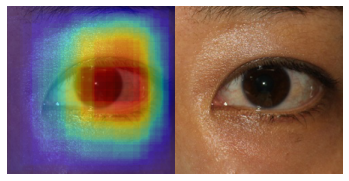

In [39]:
#最大と最小が0と255になるように補正
attention = attention_backup.copy()
min = np.amin(attention)
attention = 255*(attention -np.amin(attention))/(np.amax(attention) - np.amin(attention))
attention = attention.astype(int)
attention

#グラフを1行2列に並べたうちの1番目
plt.subplots_adjust(wspace=0,hspace=0)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image)
plt.imshow(np.array(attention), alpha=0.5, cmap='jet')

#元の画像を並べて表示
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image)

plt.savefig("colormap.png", dpi=300)

plt.show()

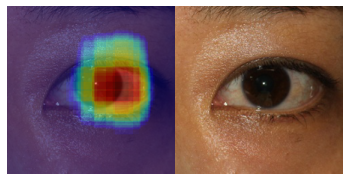

In [40]:
#マイナスを削除した上で、最大と最小が0と255になるように補正
attention = attention_backup.copy()
min = np.amin(attention)
attention[attention < 0] = 0
attention = 255*(attention -np.amin(attention))/(np.amax(attention) - np.amin(attention))
attention = attention.astype(int)

#グラフを1行2列に並べたうちの1番目
plt.subplots_adjust(wspace=0,hspace=0)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image)
plt.imshow(np.array(attention), alpha=0.5, cmap='jet')

#元の画像を並べて表示
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image)

plt.savefig("colormap.png", dpi=300)

plt.show()

In [ ]:
x = np.arange(0,224)
y = np.arange(0,224)
X, Y = np.meshgrid(x, y)
data = attention

plt.contourf(X, Y, data, cmap="jet") #等高線をプロット
plt.show() #画像の表示